In [1]:
from datatable import dt, f, by, as_type, Frame
from datetime import datetime as d
from shapely.geometry import Point, shape, Polygon
import os, shutil, glob
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
frame = dt.fread('Finish_mapping.csv')
frame.names

('C0',
 'vendor_name',
 'Trip_Pickup_DateTime',
 'Trip_Dropoff_DateTime',
 'Passenger_Count',
 'Trip_Distance',
 'Start_Lon',
 'Start_Lat',
 'End_Lon',
 'End_Lat',
 'Payment_Type',
 'Fare_Amt',
 'surcharge',
 'Tip_Amt',
 'Tolls_Amt',
 'Total_Amt',
 'pick_up_Zone',
 'pick_up_ID',
 'pick_up_borough',
 'drop_off_Zone',
 'drop_off_ID',
 'drop_off_borough')

In [3]:
shape_gdf = geopandas.read_file('taxi_zones/taxi_zones.shp')

In [4]:
# count pick up for every zone and add to shape_df
pick_up_count = frame[:,dt.count(), by('pick_up_Zone')].sort(-f.count)
pick_up_count.names = {'count':'pick_up_count'}
pick_up_count = pick_up_count.to_pandas()
shape_gdf = shape_gdf.set_index('zone').join(pick_up_count.set_index('pick_up_Zone'))

In [5]:
# count drop off for every zone and add to shape_df
drop_off_count = frame[:,dt.count(), by('drop_off_Zone')].sort(-f.count)
drop_off_count.names = {'count': 'drop_off_count'}
drop_off_count = drop_off_count.to_pandas()
shape_gdf = shape_gdf.join(drop_off_count.set_index('drop_off_Zone'))

,pick_up_count,drop_off_count,borough
Times Sq/Theatre District,1581229,1438987,Manhattan
Midtown Center,1558366,1673651,Manhattan
Upper East Side South,1546520,1402008,Manhattan
East Village,1503926,1197367,Manhattan
Upper East Side North,1424176,1446570,Manhattan
Midtown East,1401322,1301625,Manhattan
Murray Hill,1396157,1368418,Manhattan
Union Sq,1349435,1207092,Manhattan
Clinton East,1261417,1053910,Manhattan
Lincoln Square East,1240042,1127789,Manhattan


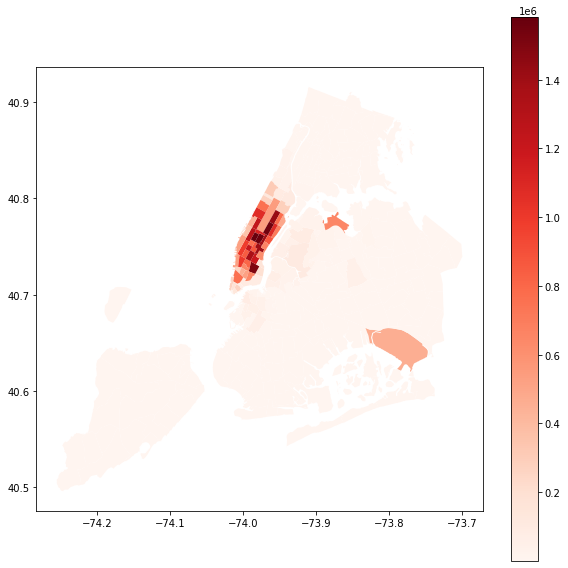

In [6]:
shape_gdf.to_crs(epsg=4326).plot(column='pick_up_count', cmap='Reds', legend=True,figsize=(10,10))
display(pd.DataFrame(shape_gdf.loc[:,['pick_up_count','drop_off_count','borough']]).sort_values('pick_up_count', ascending=False).head(10))

,pick_up_count,drop_off_count,borough
Midtown Center,1558366,1673651,Manhattan
Upper East Side North,1424176,1446570,Manhattan
Times Sq/Theatre District,1581229,1438987,Manhattan
Upper East Side South,1546520,1402008,Manhattan
Murray Hill,1396157,1368418,Manhattan
Midtown East,1401322,1301625,Manhattan
Union Sq,1349435,1207092,Manhattan
East Village,1503926,1197367,Manhattan
Lincoln Square East,1240042,1127789,Manhattan
Penn Station/Madison Sq West,1208944,1106362,Manhattan


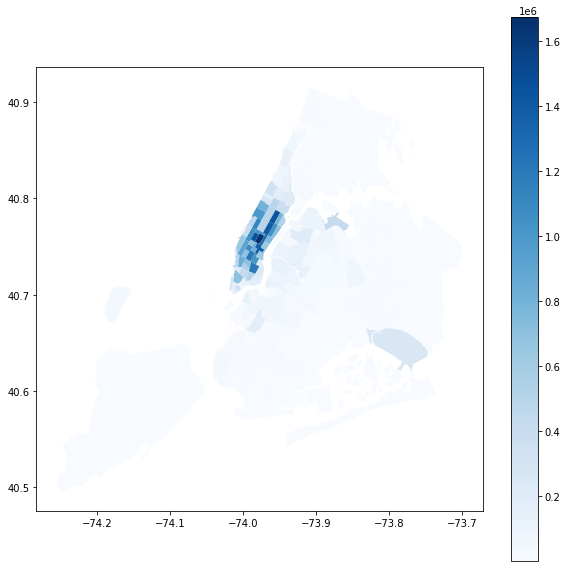

In [7]:
shape_gdf.to_crs(epsg=4326).plot(column='drop_off_count', cmap='Blues', legend=True, figsize=(10,10))
pd.DataFrame(shape_gdf.loc[:,['pick_up_count','drop_off_count','borough']]).sort_values('drop_off_count', ascending=False).head(10)

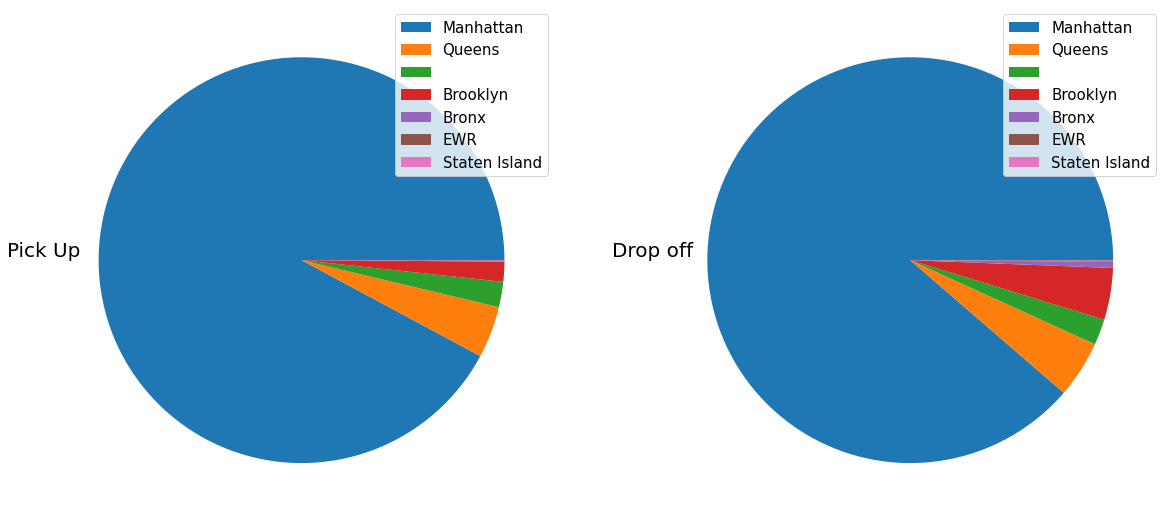

In [8]:
pick = frame[:,dt.count(), by('pick_up_borough')].sort(-f.count)
pick.names = {'pick_up_borough':'borough', 'count':'pick_up'}
drop = frame[:,dt.count(), by('drop_off_borough')].sort(-f.count)
drop.names = {'drop_off_borough':'borough', 'count':'drop_off'}
drop.key = 'borough'
combine = pick[:, :, dt.join(drop)]
combine = combine.to_pandas().set_index('borough')
fig, axes = plt.subplots(nrows=1, ncols=2)
ax1 = combine.plot.pie(ax=axes[0], y='pick_up',figsize=(20,10), labels=None)
ax1.set_ylabel('Pick Up', rotation=0, fontsize=20)
ax1.legend(labels = combine.index, fontsize=15, loc=1)
ax2 = combine.plot.pie(ax=axes[1], y='drop_off',figsize=(20,10), labels=None, legend=False)
ax2.set_ylabel('Drop off',rotation=0, fontsize=20)
ax2.legend(labels = combine.index, fontsize=15, loc=1)


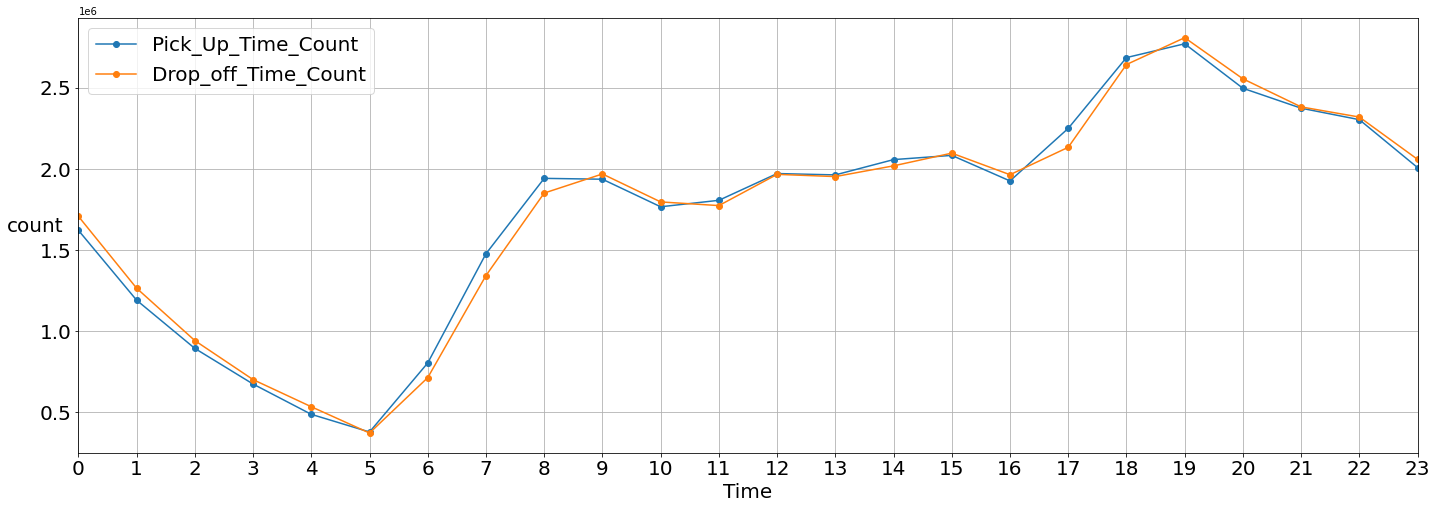

,Pick_Up_Time_Count,Drop_off_Time_Count
0,1621426,1707622
1,1191211,1264955
2,894354,942516
3,674986,702340
4,488542,535283
5,379852,373470
6,804853,714493
7,1477144,1342909
8,1941097,1850614
9,1935823,1968149


In [9]:
pick_time_count = frame[:, dt.count(), by('Trip_Pickup_DateTime')]
pick_time_count.names = {'count':'Pick_Up_Time_Count', 'Trip_Pickup_DateTime': 'Time'}
drop_time_count = frame[:, dt.count(), by('Trip_Dropoff_DateTime')]
drop_time_count.names = {'count':'Drop_off_Time_Count', 'Trip_Dropoff_DateTime':'Time'}
drop_time_count.key = 'Time'
combine = pick_time_count[:, :, dt.join(drop_time_count)]
ax = combine.to_pandas().plot(x='Time', y=['Pick_Up_Time_Count','Drop_off_Time_Count'], 
                              kind='line', style='-o', grid=True, figsize=(24, 8))
ax.set_ylabel('count', fontsize=20, rotation=0)
ax.set_xlabel('Time', fontsize=20, rotation=0)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlim(0, 23)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()
display(combine.to_pandas().drop('Time', axis=1))

In [10]:
amt = frame[:,['Fare_Amt','surcharge', 'Tolls_Amt', 'Tip_Amt','Total_Amt']]
f_dict = {'Fare':'Fare_Amt', 'Surcharge':'surcharge', 'Tip':'Tip_Amt', 'Tolls':'Tolls_Amt', 'Total':'Total_Amt'}

def static_amt(amt, fd):
    print(f'{fd[0]}')
    v = amt[fd[1]]
    print(f'\t     Min: {amt[:, dt.min(v)].to_numpy()[0][0]} \n \
            Max: {amt[:, dt.max(v)].to_numpy()[0][0]} \n \
            Median: {amt[:, dt.median(v)].to_numpy()[0][0]} \n \
            Mean: {amt[:, dt.mean(v)].to_numpy()[0][0]:.4f} \n \
            Std: {amt[:, dt.sd(v)].to_numpy()[0][0]:.4f} \n \
          ')

for fd in f_dict.items():
    static_amt(amt, fd)

Fare
	     Min: 2.5 
             Max: 200.0 
             Median: 7.7 
             Mean: 9.6808 
             Std: 7.3570 
           
Surcharge
	     Min: 0.0 
             Max: 5.0 
             Median: 0.0 
             Mean: 0.1826 
             Std: 0.3212 
           
Tip
	     Min: 0.0 
             Max: 100.0 
             Median: 0.0 
             Mean: 0.4990 
             Std: 1.3405 
           
Tolls
	     Min: 0.0 
             Max: 20.0 
             Median: 0.0 
             Mean: 0.1257 
             Std: 0.7609 
           
Total
	     Min: 2.5 
             Max: 235.2 
             Median: 8.1 
             Mean: 10.4911 
             Std: 8.3936 
           


<AxesSubplot:>

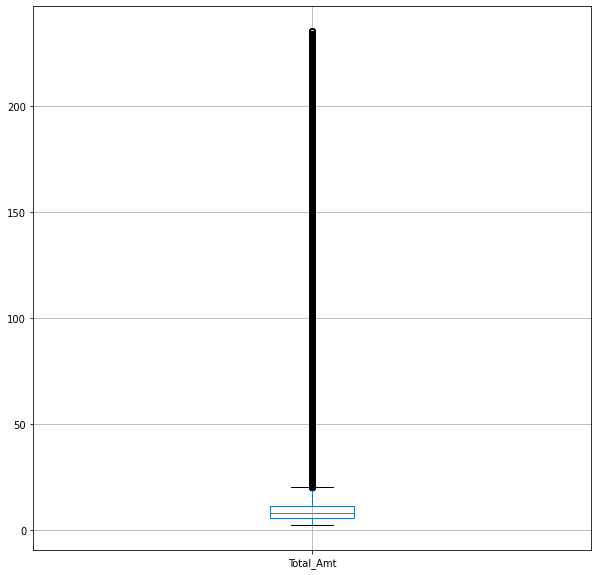

In [11]:
amt_df = frame[:,'Total_Amt'].to_pandas()

amt_df.boxplot(autorange=True, meanline=True, figsize=(10, 10))

In [12]:
frame[:, dt.corr(f.Total_Amt, f.Trip_Distance)]

,C0
,▪▪▪▪▪▪▪▪
0,0.88357


In [13]:
amt_df.Total_Amt.quantile([0, 0.25, 0.5, 0.75, 1.0])

0.00      2.5
0.25      5.9
0.50      8.1
0.75     11.7
1.00    235.2
Name: Total_Amt, dtype: float64

,count,Small Amount,Big Amount
,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪
0,1621426,324623,542418
1,1191211,243043,403227
2,894354,182669,312516
3,674986,136146,250014
4,488542,101939,199077
5,379852,99265,141968
6,804853,275197,187075
7,1477144,471533,299475
8,1941097,570051,412279


(0.0, 23.0)

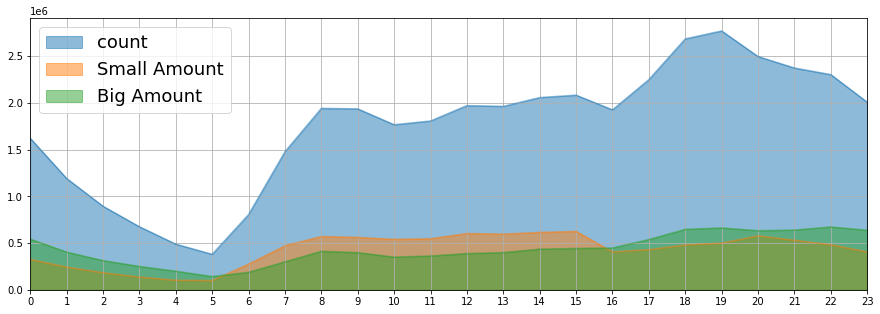

In [14]:
# st: small_time, sr: small_region
small = frame[f.Total_Amt < 5.9, :]
big = frame[f.Total_Amt > 11.7, :]
t = frame[:, dt.count(), by('Trip_Pickup_DateTime')]
st = small[:, dt.count(), by('Trip_Pickup_DateTime')]
bt = big[:, dt.count(), by('Trip_Pickup_DateTime')]
st.key='Trip_Pickup_DateTime'
bt.key='Trip_Pickup_DateTime'
t = t[:, :, dt.join(st)]
t = t[:, :, dt.join(bt)]
t.names = {'count.0': 'Small Amount', 'count.1':'Big Amount'}
del t['Trip_Pickup_DateTime']
display(t)
ax = t.to_pandas().plot.area(stacked=False, grid=True, figsize=(15,5))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend(fontsize=18)
plt.xlim(0, 23)

pick_up_borough,Small Amount,Big Amount
▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪
,208627,230988
Bronx,12615,11944
Brooklyn,122771,301201
EWR,486,3090
Manhattan,9758214,8567074
Queens,191964,1281134
Staten Island,691,809


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(1, 0, 'Bronx'),
  Text(2, 0, 'Brooklyn'),
  Text(3, 0, 'EWR'),
  Text(4, 0, 'Manhattan'),
  Text(5, 0, 'Queens'),
  Text(6, 0, 'Staten Island'),
  Text(0, 0, ''),
  Text(0, 0, '')])

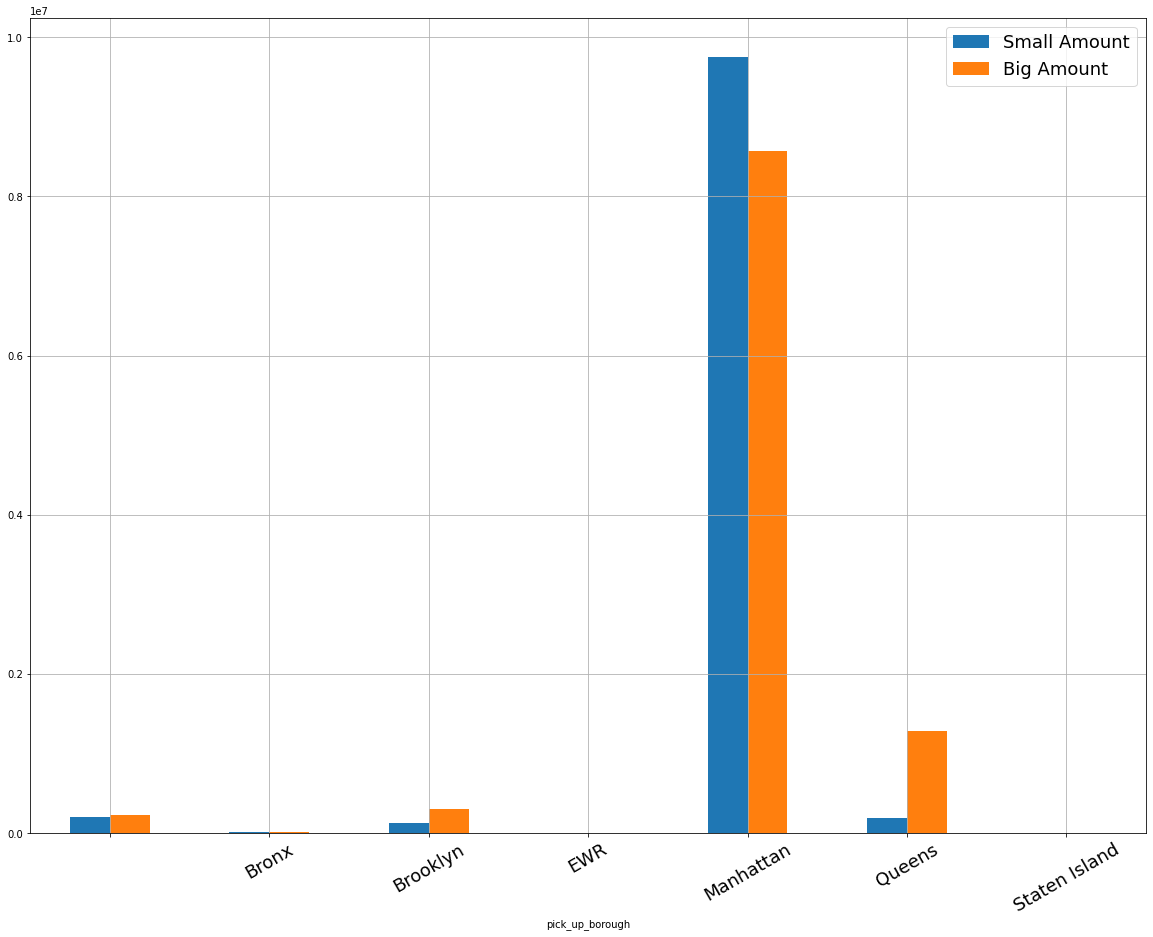

In [15]:
small = frame[f.Total_Amt < 5.9, :]
big = frame[f.Total_Amt > 11.7, :]
r = frame[:, dt.count(), by('pick_up_borough')]
sr = small[:, dt.count(), by('pick_up_borough')]
br = big[:, dt.count(), by('pick_up_borough')]
sr.key='pick_up_borough'
br.key='pick_up_borough'
r = r[:, :, dt.join(sr)]
r = r[:, :, dt.join(br)]
r.names = {'count.0': 'Small Amount', 'count.1':'Big Amount'}
del r['count']
r.key = 'pick_up_borough'
display(r)
ax = r.to_pandas().plot.bar(stacked=False, grid=True, figsize=(20,15))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend(fontsize=18)
plt.xticks(rotation=30, fontsize=18)


drop_off_borough,Small Amount,Big Amount
▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪
,205203,252634
Bronx,12574,172314
Brooklyn,125553,1262375
EWR,548,41425
Manhattan,9759150,7216783
Queens,191660,1442614
Staten Island,680,8095


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(1, 0, 'Bronx'),
  Text(2, 0, 'Brooklyn'),
  Text(3, 0, 'EWR'),
  Text(4, 0, 'Manhattan'),
  Text(5, 0, 'Queens'),
  Text(6, 0, 'Staten Island'),
  Text(0, 0, ''),
  Text(0, 0, '')])

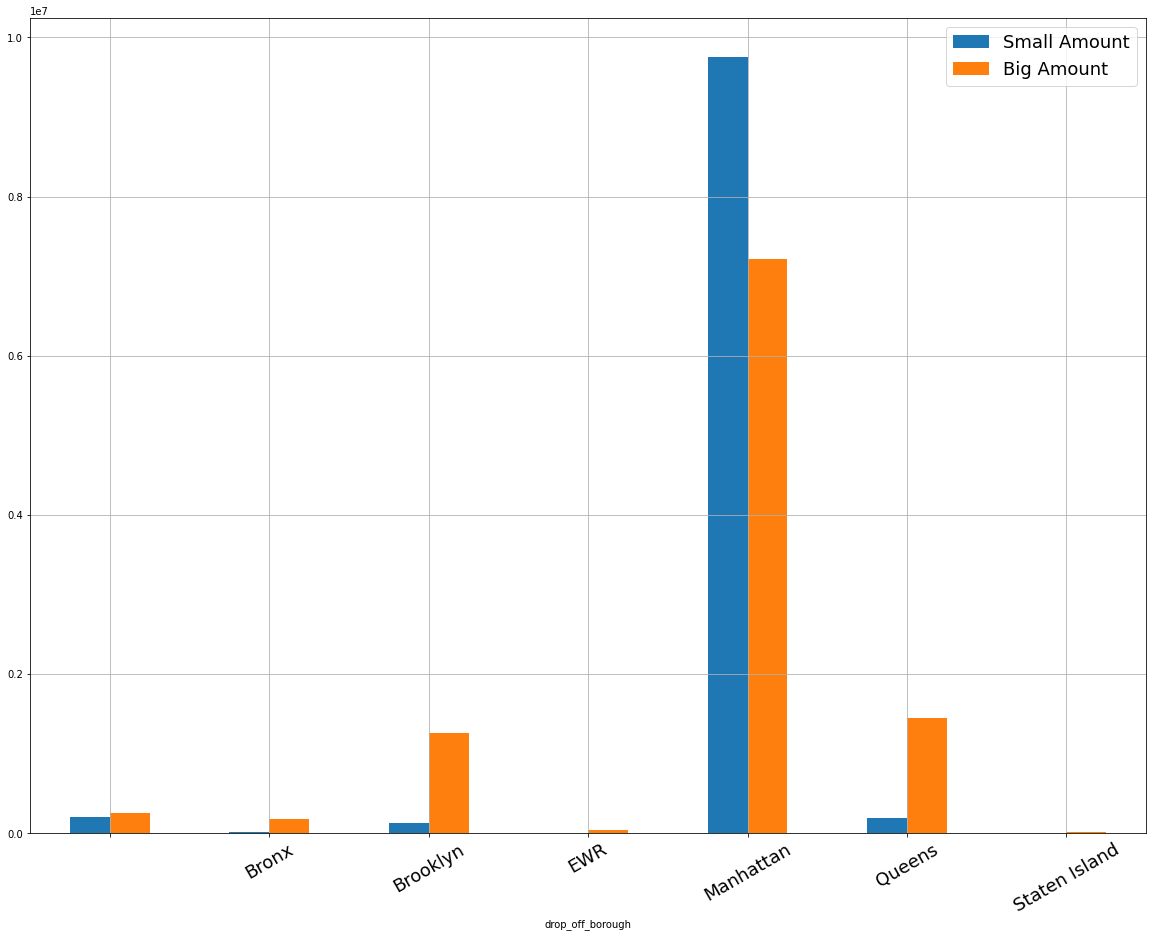

In [16]:
small = frame[f.Total_Amt < 5.9, :]
big = frame[f.Total_Amt > 11.7, :]
r = frame[:, dt.count(), by('drop_off_borough')]
sr = small[:, dt.count(), by('drop_off_borough')]
br = big[:, dt.count(), by('drop_off_borough')]
sr.key='drop_off_borough'
br.key='drop_off_borough'
r = r[:, :, dt.join(sr)]
r = r[:, :, dt.join(br)]
r.names = {'count.0': 'Small Amount', 'count.1':'Big Amount'}
del r['count']
r.key = 'drop_off_borough'
display(r)
ax = r.to_pandas().plot.bar(stacked=False, grid=True, figsize=(20,15))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend(fontsize=18)
plt.xticks(rotation=30, fontsize=18)